# Import Packages

In [1]:
import torch
from torch import nn
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import time
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import FeaturePyramidNetwork
import torch.nn.functional as F
from torchvision.ops import FeaturePyramidNetwork

# Function of Display Training Progress

In [2]:
# plot 4 metrics during training progress
def plot_training_progress(results_path):
    data = torch.load(results_path)
    fig, ax1 = plt.subplots()
    plt.plot(data["train_loss"], 'r', label = 'train_loss')
    plt.plot(data["val_loss"], 'm', label = 'val_loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    ax2=ax1.twinx()
    plt.plot(data["train_accuracy"], 'g', label = 'train_accuracy')
    plt.plot(data["val_accuracy"], 'b', label = 'val_accuracy')
    plt.legend(loc='lower right')
    ax2.set_ylabel('accuracy')

    plt.show()

# ResNet - No Image Augmentation

In [9]:
# 定义 ResNet 模型
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        # 加载预训练的 ResNet 模型
        self.backbone = resnet50(pretrained=True)

        # 替换最后的全连接层
        self.backbone.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x
    
# time recording start
start_time = time.time()

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
dataset = ImageFolder(root="./MO_106/", transform=transform)

# 数据集分割为训练集、验证集和测试集
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Training loop
num_epochs = 10
batch_size = 128
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# 定义模型
model = ResNet(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


Epoch 1/10: Train Loss: 3.2770, Train Accuracy: 0.3276, Val Loss: 2.0420, Val Accuracy: 0.5442
Epoch 2/10: Train Loss: 1.4731, Train Accuracy: 0.6718, Val Loss: 1.3039, Val Accuracy: 0.6732
Epoch 3/10: Train Loss: 0.7303, Train Accuracy: 0.8423, Val Loss: 1.0157, Val Accuracy: 0.7299
Epoch 4/10: Train Loss: 0.3251, Train Accuracy: 0.9449, Val Loss: 0.9243, Val Accuracy: 0.7500
Epoch 5/10: Train Loss: 0.1227, Train Accuracy: 0.9883, Val Loss: 0.8877, Val Accuracy: 0.7552
Epoch 6/10: Train Loss: 0.0514, Train Accuracy: 0.9975, Val Loss: 0.8511, Val Accuracy: 0.7665
Epoch 7/10: Train Loss: 0.0237, Train Accuracy: 0.9996, Val Loss: 0.8472, Val Accuracy: 0.7672
Epoch 8/10: Train Loss: 0.0180, Train Accuracy: 0.9995, Val Loss: 0.8442, Val Accuracy: 0.7694
Epoch 9/10: Train Loss: 0.0143, Train Accuracy: 0.9995, Val Loss: 0.8499, Val Accuracy: 0.7701
Epoch 10/10: Train Loss: 0.0082, Train Accuracy: 0.9999, Val Loss: 0.8446, Val Accuracy: 0.7716
Training took 2215.95 seconds.
Test accuracy: 75.

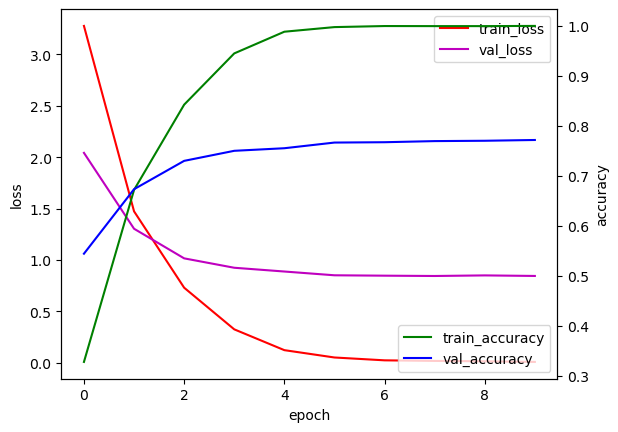

In [12]:
plot_training_progress(results_path)

# ResNet - With Image Augmentation

In [ ]:
# 定义 ResNet 模型
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        # 加载预训练的 ResNet 模型
        self.backbone = resnet50(pretrained=True)

        # 替换最后的全连接层
        self.backbone.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x
    
# time recording start
start_time = time.time()

# Transformations for Training, includes data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the image to 224x224 pixels while keeping aspect ratio
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change the brightness, contrast and saturation of the image
    transforms.RandomRotation(10),  # Randomly rotate the image within the range of (-10. +10) degrees
    transforms.ToTensor(),  # Convert PIL Image or numpy.ndarray to tensor, and normalize to [0-1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize to [-1, 1], mean and std deviation are from ImageNet
])

# Transformations for Validation and Testing, no data augmentation
transform_test_and_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image with precomputed ImageNet mean and std deviation
])

train_dataset = ImageFolder(root="./MO_106_train", transform=transform_train)
val_dataset = ImageFolder(root="./MO_106_val", transform=transform_test_and_val)
test_dataset = ImageFolder(root="./MO_106_test", transform=transform_test_and_val)


# Training loop
num_epochs = 10
batch_size = 128
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# 定义模型
model = ResNet(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


Epoch 1/10: Train Loss: 3.2770, Train Accuracy: 0.3276, Val Loss: 2.0420, Val Accuracy: 0.5442
Epoch 2/10: Train Loss: 1.4731, Train Accuracy: 0.6718, Val Loss: 1.3039, Val Accuracy: 0.6732
Epoch 3/10: Train Loss: 0.7303, Train Accuracy: 0.8423, Val Loss: 1.0157, Val Accuracy: 0.7299
Epoch 4/10: Train Loss: 0.3251, Train Accuracy: 0.9449, Val Loss: 0.9243, Val Accuracy: 0.7500
Epoch 5/10: Train Loss: 0.1227, Train Accuracy: 0.9883, Val Loss: 0.8877, Val Accuracy: 0.7552
Epoch 6/10: Train Loss: 0.0514, Train Accuracy: 0.9975, Val Loss: 0.8511, Val Accuracy: 0.7665
Epoch 7/10: Train Loss: 0.0237, Train Accuracy: 0.9996, Val Loss: 0.8472, Val Accuracy: 0.7672
Epoch 8/10: Train Loss: 0.0180, Train Accuracy: 0.9995, Val Loss: 0.8442, Val Accuracy: 0.7694
Epoch 9/10: Train Loss: 0.0143, Train Accuracy: 0.9995, Val Loss: 0.8499, Val Accuracy: 0.7701
Epoch 10/10: Train Loss: 0.0082, Train Accuracy: 0.9999, Val Loss: 0.8446, Val Accuracy: 0.7716
Training took 2215.95 seconds.
Test accuracy: 75.

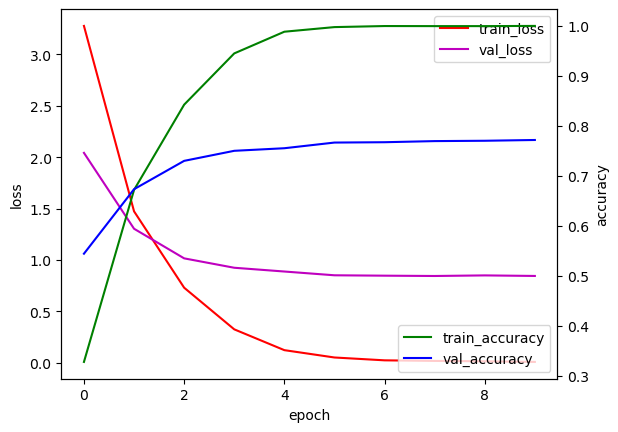

In [ ]:
plot_training_progress(results_path)

# ResNet - With Image Augmentation - Featurized Image Pyramid

In [3]:
class ResNetFIP(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFIP, self).__init__()
        
        # 加载预训练的ResNet模型
        self.backbone = resnet50(pretrained=True)
        
        # 获取ResNet中的不同层的输出大小
        self.conv1 = self.backbone.conv1
        self.bn1 = self.backbone.bn1
        self.relu = self.backbone.relu
        self.maxpool = self.backbone.maxpool
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        
        # 使用Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(in_channels_list=[256, 512, 1024, 2048],
                                          out_channels=256)
        
        # 分类层
        self.fc1 = nn.Linear(256, num_classes)
        self.fc2 = nn.Linear(256, num_classes)
        self.fc3 = nn.Linear(256, num_classes)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        # ResNet部分
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        # FPN部分
        features = self.fpn({"0": x1, "1": x2, "2": x3, "3": x4})
        
        # 分类部分
        out1 = self.fc1(F.adaptive_avg_pool2d(features["0"], (1, 1)).view(x.size(0), -1))
        out2 = self.fc2(F.adaptive_avg_pool2d(features["1"], (1, 1)).view(x.size(0), -1))
        out3 = self.fc3(F.adaptive_avg_pool2d(features["2"], (1, 1)).view(x.size(0), -1))
        out4 = self.fc4(F.adaptive_avg_pool2d(features["3"], (1, 1)).view(x.size(0), -1))
        
        out = out1 + out2 + out3 + out4
        
        return out

    
# time recording start
start_time = time.time()

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
dataset = ImageFolder(root="./MO_106/", transform=transform)

# 数据集分割为训练集、验证集和测试集
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Training loop
num_epochs = 10
batch_size = 128
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# 定义模型
model = ResNetFIP(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_fip_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10: Train Loss: 2.4164, Train Accuracy: 0.4261, Val Loss: 1.3086, Val Accuracy: 0.6287
Epoch 2/10: Train Loss: 0.7947, Train Accuracy: 0.7785, Val Loss: 1.0173, Val Accuracy: 0.7053
Epoch 3/10: Train Loss: 0.2599, Train Accuracy: 0.9384, Val Loss: 0.9388, Val Accuracy: 0.7323
Epoch 4/10: Train Loss: 0.0714, Train Accuracy: 0.9899, Val Loss: 0.9450, Val Accuracy: 0.7467
Epoch 5/10: Train Loss: 0.0252, Train Accuracy: 0.9983, Val Loss: 0.9441, Val Accuracy: 0.7500
Epoch 6/10: Train Loss: 0.0123, Train Accuracy: 0.9994, Val Loss: 0.9631, Val Accuracy: 0.7552
Epoch 7/10: Train Loss: 0.0051, Train Accuracy: 0.9998, Val Loss: 0.9861, Val Accuracy: 0.7543
Epoch 8/10: Train Loss: 0.0045, Train Accuracy: 0.9998, Val Loss: 0.9857, Val Accuracy: 0.7593
Epoch 9/10: Train Loss: 0.0032, Train Accuracy: 0.9998, Val Loss: 1.0098, Val Accuracy: 0.7552
Epoch 10/10: Train Loss: 0.0036, Train Accuracy: 0.9998, Val Loss: 1.0123, Val Accuracy: 0.7603
Training took 2388.82 seconds.
Test accuracy: 74.

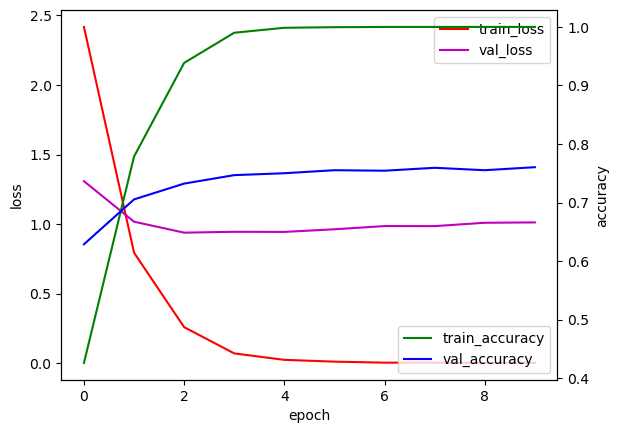

In [4]:
plot_training_progress(results_path)

# ResNet - With Image Augmentation - Feature Pyramid Network

In [12]:
class ResNetFPN(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFPN, self).__init__()
        
        # Load pretrained ResNet model
        self.backbone = resnet50(pretrained=True)
        
        # Get the output size of different layers in ResNet
        self.conv1 = self.backbone.conv1
        self.bn1 = self.backbone.bn1
        self.relu = self.backbone.relu
        self.maxpool = self.backbone.maxpool
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        
        # Use Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(in_channels_list=[256, 512, 1024, 2048],
                                          out_channels=256)
        
        # Classification layers for each FPN output
        # self.fc1 = nn.Linear(256, num_classes)
        # self.fc2 = nn.Linear(256, num_classes)
        # self.fc3 = nn.Linear(256, num_classes)
        # self.fc4 = nn.Linear(256, num_classes)
        # self.fc1 = nn.Sequential(nn.Linear(256, num_classes), nn.Dropout(0.5))
        # self.fc2 = nn.Sequential(nn.Linear(256, num_classes), nn.Dropout(0.5))
        # self.fc3 = nn.Sequential(nn.Linear(256, num_classes), nn.Dropout(0.5))
        # self.fc4 = nn.Sequential(nn.Linear(256, num_classes), nn.Dropout(0.5))
        # self.fc1 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc2 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc3 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc4 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        self.fc1 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, num_classes))
        self.fc2 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, num_classes))
        self.fc3 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, num_classes))
        self.fc4 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, num_classes))

        
        # Final classification layer
        self.fc_final = nn.Linear(num_classes * 4, num_classes)

    def forward(self, x):
        # ResNet part
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        # FPN part
        features = self.fpn({"0": x1, "1": x2, "2": x3, "3": x4})
        
        # Classification part
        out1 = self.fc1(F.adaptive_avg_pool2d(features["0"], (1, 1)).view(x.size(0), -1))
        out2 = self.fc2(F.adaptive_avg_pool2d(features["1"], (1, 1)).view(x.size(0), -1))
        out3 = self.fc3(F.adaptive_avg_pool2d(features["2"], (1, 1)).view(x.size(0), -1))
        out4 = self.fc4(F.adaptive_avg_pool2d(features["3"], (1, 1)).view(x.size(0), -1))
        
        # Concatenate the classification results of each FPN output
        out = torch.cat((out1, out2, out3, out4), dim=1)
        
        # Final classification
        out = self.fc_final(out)
        
        return out

    
# time recording start
start_time = time.time()

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
dataset = ImageFolder(root="./MO_106/", transform=transform)

# 数据集分割为训练集、验证集和测试集
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Training loop
num_epochs = 10
batch_size = 128
lr = 0.00002

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# 定义模型
model = ResNetFPN(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_fpn_dp_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


Epoch 1/10: Train Loss: 4.4082, Train Accuracy: 0.0709, Val Loss: 3.7505, Val Accuracy: 0.2134
Epoch 2/10: Train Loss: 3.2213, Train Accuracy: 0.2409, Val Loss: 2.4945, Val Accuracy: 0.4127
Epoch 3/10: Train Loss: 2.2608, Train Accuracy: 0.4129, Val Loss: 1.8659, Val Accuracy: 0.5325
Epoch 4/10: Train Loss: 1.6453, Train Accuracy: 0.5444, Val Loss: 1.5366, Val Accuracy: 0.5978
Epoch 5/10: Train Loss: 1.1984, Train Accuracy: 0.6542, Val Loss: 1.3706, Val Accuracy: 0.6284
Epoch 6/10: Train Loss: 0.8533, Train Accuracy: 0.7552, Val Loss: 1.3003, Val Accuracy: 0.6469
Epoch 7/10: Train Loss: 0.5936, Train Accuracy: 0.8333, Val Loss: 1.2598, Val Accuracy: 0.6612
Epoch 8/10: Train Loss: 0.4036, Train Accuracy: 0.8875, Val Loss: 1.2789, Val Accuracy: 0.6577
Epoch 9/10: Train Loss: 0.2721, Train Accuracy: 0.9285, Val Loss: 1.2949, Val Accuracy: 0.6646
Epoch 10/10: Train Loss: 0.1867, Train Accuracy: 0.9548, Val Loss: 1.3307, Val Accuracy: 0.6684
Training took 2701.53 seconds.
Test accuracy: 65.

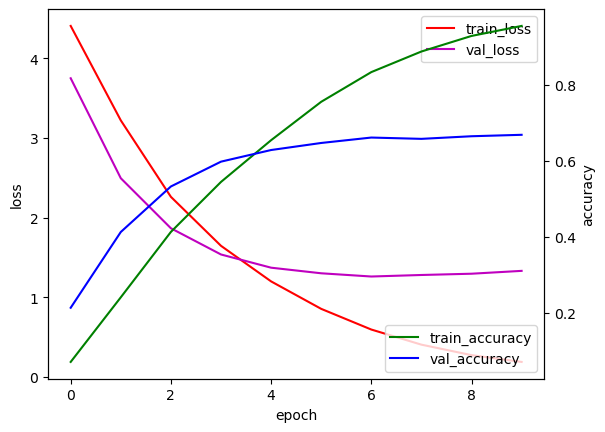

In [13]:
plot_training_progress(results_path)

# EfficientNet-B7 - With Image Augmentation

In [ ]:
# 定义 ResNet 模型
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        # 加载预训练的 ResNet 模型
        self.backbone = resnet50(pretrained=True)

        # 替换最后的全连接层
        self.backbone.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x
    
# time recording start
start_time = time.time()

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
dataset = ImageFolder(root="./MO_106/", transform=transform)

# 数据集分割为训练集、验证集和测试集
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Training loop
num_epochs = 10
batch_size = 128
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# 定义模型
model = ResNet(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')
